# 13E054VI Veštačka inteligencija

**Prvi domaći zadatak**  
student: Aleksandra Ljubenović 2020/0117

U ovom zadatku bilo je potrebno primeniti algoritam simuliranog kaljenja za nalaženje globalnog minimuma funkcije f(x) na unapred definisanom domenu i uporediti dobijene rezultate sa slučajnom (nasumičnom) pretragom.

Prilikom realizacije simuliranog kaljenja, odabran je eksponencijalan profil hlađenja (*T_new = cooling_rate x T_old*), pri čemu je početna temperatura određena kao 10 % od opsega promene vrednosti funkcije f(x) na posmatranom domenu. Pretraga se završava kada temperatura padne ispod unapred definisanog praga (odabrano je 0.01), ili kada broj iteracija dostigne unapred definisanu maksimalnu vrednost. U okviru ovog algoritma, susedi posmatranih tačaka prostora određivani kao ranije neposećene tačke generisane tako što je trenutnoj tački dodat odgovarajući pomeraj. Svaka prostorna koordinata ovog pomeraja predstavlja jednu realizaciju pseudoslučajne promenljive sa uniformnom raspodelom na intervalu [-0.5, 0.5]. Prilikom dodavanja pomeraja, vođeno je računa da koordinate novodobijene tačke prostora pripadaju intervalu od interesa (interval [0, 2]). Koordinate posmatranih tačaka u prostoru uvek su zaokruživane na 3 decimale, što rezultuje time da je umesto kontinualnog zapravo posmatran diskretan prostor.

<u>Definisanje korišćenih funkcija</u>

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Function definitions

def f_x(x):

    (x1,x2,x3) = x
    f = 4/3*(x1**2+x2**2-x1*x2)**0.75+x3
    return f


def random_search(x_init,x_range,max_iter):

    # initialization of variables
    x = x_init; x_visited = [x]; x_best = [x]
    f = f_x(x)

    # random search
    (x_min,x_max) = x_range
    x_arr = [(np.random.uniform(x_min,x_max), np.random.uniform(x_min,x_max), np.random.uniform(x_min,x_max)) for _ in range(max_iter)]
    x_arr = [np.round(x,3) for x in x_arr]
    for i in range(max_iter):
        x_tmp = x_arr[i]
        f_tmp = f_x(x_tmp)
        if f_tmp < f:
            x = x_tmp
            f = f_tmp
        x_visited.append(x_tmp)
        x_best.append(x)
            
    return (x,f,x_visited,x_best)

 
def simulated_annealing(x_init, x_range, T_schedule, threshold, max_iter, M):

    def evaluate_neighbour(x, x_range, max_shift):
    
        (x_min, x_max) = x_range
        x_shift = tuple([max_shift*np.random.uniform(-1,1) for _ in range(3)])
        x_next = np.clip(np.round(x+x_shift,decimals=3), x_min, x_max)

        return x_next

    # initialization of variables
    x = x_init; x_min = x;  x_visited = [x]; x_best = [x]
    f = f_x(x); f_min = f
    k = 0
    T = T_schedule[k]
    max_shift = 0.5

    # simulated annealing
    while(T > threshold and k < max_iter):
        for _ in range(M):
            x_tmp = evaluate_neighbour(x, x_range, max_shift)
            f_tmp = f_x(x_tmp)

            delta = f_tmp-f
            if delta <= 0:
                x = x_tmp; f = f_tmp
            else:
                p = np.random.rand()
                T = T_schedule[k]
                if p <= np.e**(-delta/T):
                    x = x_tmp
                    f = f_tmp
            if f < f_min:
                x_min = x
                f_min = f
            x_visited.append(x_tmp)
            x_best.append(x_min)
        k += 1

    return (x_min,f_min,x_visited,x_best)

<u>Simulirano kaljenje</u>

Izvršavanjem simuliranog kaljenja za više različitih stepena hlađenja procenjeno je da se najbolji rezultati dobijaju za stepen hlađenja *cooling rate = 0.8*, jer u ovom slučaju temperatura ne opada ni previše brzo ni previše sporo, čime je postignut kompromis između broja potrebnih iteracija algoritma i mogućnosti da se algoritam zaglavi u nekom lokalnom minimumu koji nije globalni minimum.   

U nastavku je prikazan profil hlađenja koji odgovara ovom stepenu hlađenja, kao i rezultat jednog izvršavanja simuliranog kaljenja za ovakav profil temperature. Na osnovu prikazanih grafika zaključuje se da je algoritam u ovom slučaju tačno procenio globalni minimum posmatrane funkcije.

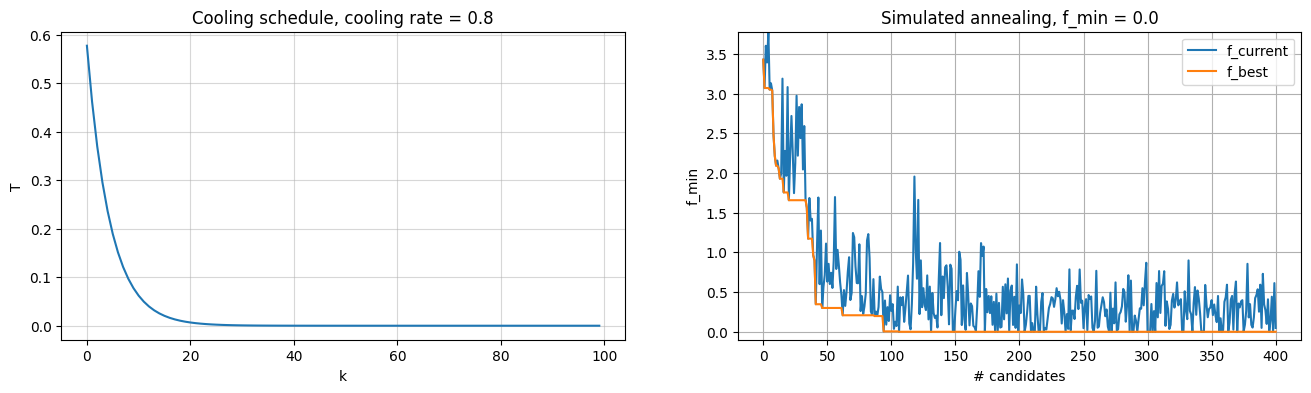

In [52]:
# ---main---

x_min = 0
x_max = 2

# determining the range of the function values
x_samples = np.linspace(x_min, x_max, 100)
X1, X2, X3 = np.meshgrid(x_samples, x_samples, x_samples, indexing='ij')
x_samples = np.vstack((X1.flatten(), X2.flatten(), X3.flatten())).T
f_values = np.array([f_x(x) for x in x_samples])
f_min_rough_est = np.min(f_values)
f_max_rough_est = np.max(f_values)
f_range_est = f_max_rough_est-f_min_rough_est

# Simulated annealing

# initialization of variables
x_init = np.random.uniform(x_min, x_max, size=(3,))
x_init = np.round(x_init, decimals=3)

max_iter = 100
M = 20
T_init = 0.1*f_range_est
alpha = 0.8
T_schedule =  [alpha**(i)*T_init for i in range(max_iter)]
threshold = 1e-2

# function minimization
(x, f_min, x_visited, x_best) = simulated_annealing(x_init, (x_min,x_max), T_schedule, threshold, max_iter, M)
f_visited = [np.round(f_x(x), decimals=3) for x in x_visited]
f_best = [np.round(f_x(x), decimals=3) for x in x_best]
f_min = np.round(f_best[-1],3)

# display of results
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(T_schedule); plt.grid(alpha=0.5)
plt.xlabel('k'); plt.ylabel('T'); plt.title('Cooling schedule, cooling rate = {}'.format(alpha))
plt.subplot(1,2,2)
plt.plot(f_visited, label = "f_current")
plt.plot(f_best, label = "f_best")
plt.xlabel('# candidates'); plt.ylabel('f_min')
plt.title('Simulated annealing, f_min = {}'.format(f_min))
plt.legend(loc='upper right'); plt.ylim((-0.1,max(f_visited))); plt.grid()


<u>Simulirano kaljenje za različite profile temperature</u>    

U nastavku su prikazani rezultati simuliranog kaljenja (uprosečeni na 100 iteracija) za tri različita profila temperature: profil u kome temperatura opada previše brzo (*cooling rate = 0.2*, algoritam je sklon da se zaglavi u nekom lokalnom minimumu), profil koji je procenjen najadekvatnijim za definisani problem (*cooling rate = 0.8*) i profil u kome temperatura opada previše sporo (*cooling rate = 0.99*, veća je verovatnoća da će algoritam konvergirati ka globalnom minimumu, ali je za to potreban veći broj iteraija).

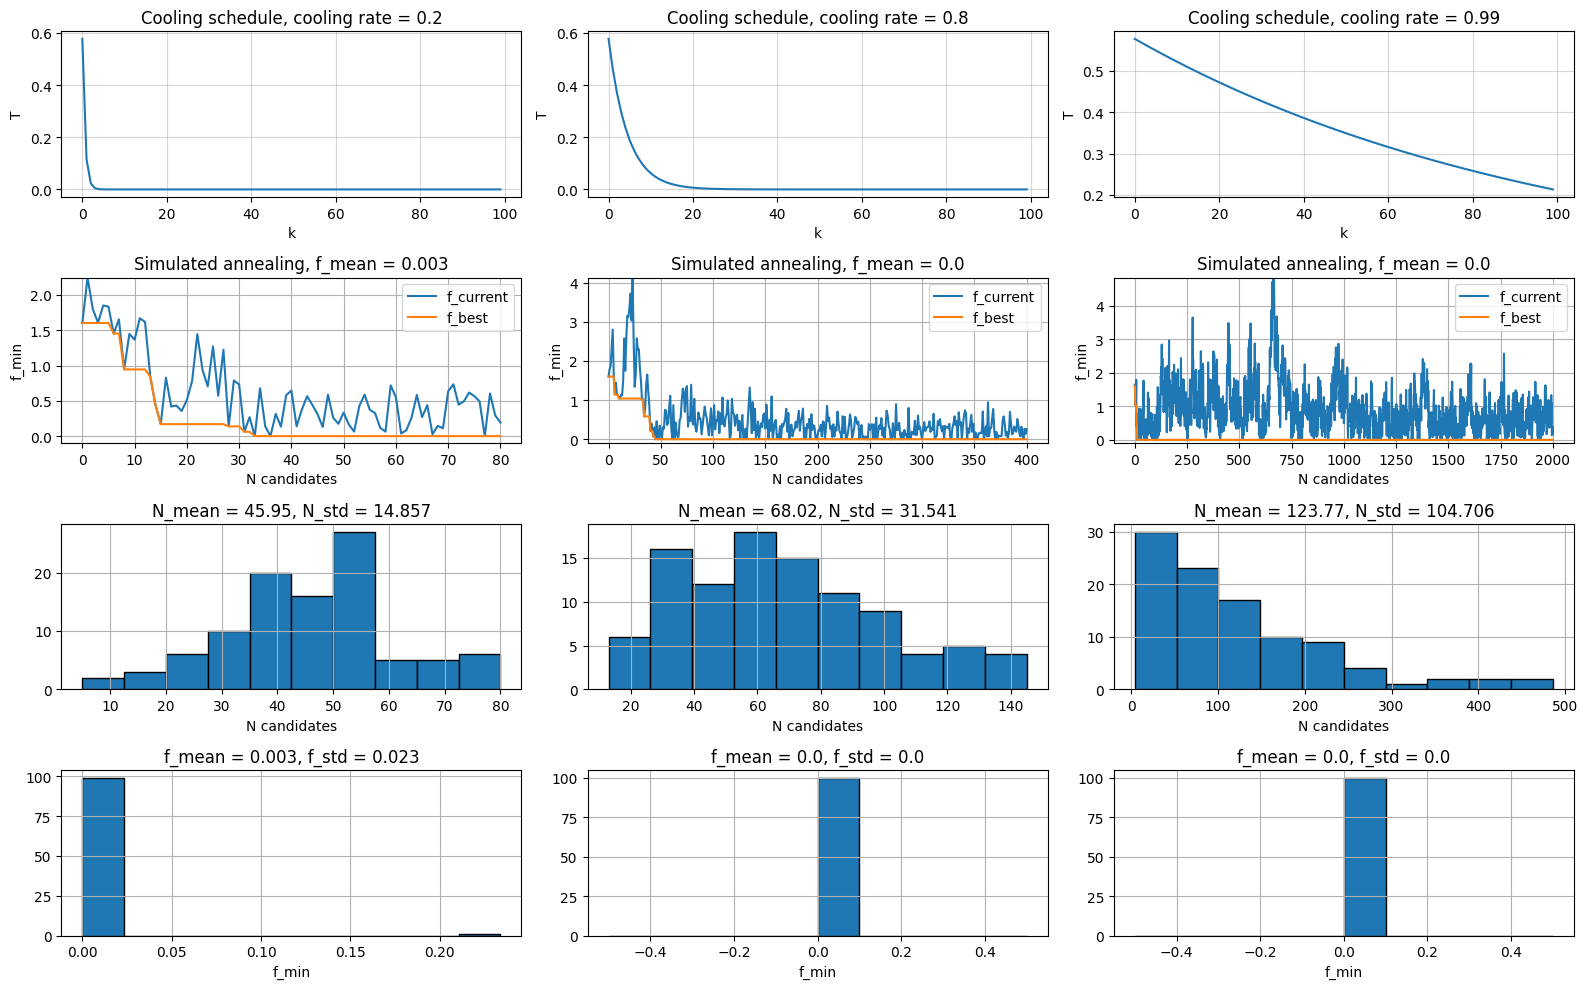

In [53]:
# performing simulated annealing for different cooling profiles

alpha_arr = [0.2, 0.8, 0.99]

N = 100
x_init_arr = [np.round(np.random.uniform(x_min,x_max, size=(3,)),decimals=3) for _ in range(N)]

N_mean_arr = np.zeros((4,)); N_std_arr = np.zeros((4,))
f_mean_arr = np.zeros((4,)); f_std_arr = np.zeros((4,))

plt.figure(figsize=(16,10))
for i in range(3):

    alpha = alpha_arr[i]
    T_schedule = [alpha**(i)*T_init for i in range(max_iter)]

    f_visited_list = []; f_best_list = []
    N_candidates = np.zeros((N,))
    f_min_arr = np.zeros((N,))

    for j in range(N):
        (x, f_min, x_visited, x_best) = simulated_annealing(x_init_arr[j], (x_min,x_max), T_schedule, threshold, max_iter, M)
        f_visited = [np.round(f_x(x), decimals=3) for x in x_visited]
        f_best = [np.round(f_x(x), decimals=3) for x in x_best]
        f_min = np.round(f_best[-1],3)

        f_visited_list.append(f_visited)
        f_best_list.append(f_best)
        
        N_candidates[j] = np.where(f_visited == f_min)[0][0] + 1
        f_min_arr[j] = f_min
    
    f_current_avg = np.mean(np.array(f_visited_list),axis=0)
    f_best_avg = np.mean(np.array(f_best_list),axis=0)

    N_mean_arr[i+1] = np.round(np.mean(N_candidates),3)
    N_std_arr[i+1] = np.round(np.std(N_candidates),3)
    
    f_mean_arr[i+1] = np.round(np.mean(f_min_arr),3)
    f_std_arr[i+1] = np.round(np.std(f_min_arr),3)
    
    # display of results
    plt.subplot(4,3,1+i)
    plt.plot(T_schedule); plt.grid(alpha=0.5)
    plt.xlabel('k'); plt.ylabel('T'); plt.title('Cooling schedule, cooling rate = {}'.format(alpha))
    plt.subplot(4,3,4+i)
    plt.plot(f_visited, label = "f_current")
    plt.plot(f_best, label = "f_best")
    plt.xlabel('N candidates'); plt.ylabel('f_min')
    plt.title('Simulated annealing, f_mean = {}'.format(f_mean_arr[i+1]))
    plt.legend(loc='upper right'); plt.ylim((-0.1,max(f_visited))); plt.grid()
    plt.subplot(4,3,7+i)
    plt.hist(N_candidates, edgecolor='black', bins= int(np.sqrt(N))); plt.grid()
    plt.xlabel('N candidates'); plt.title('N_mean = {}, N_std = {}'.format(N_mean_arr[i+1],N_std_arr[i+1]))
    plt.subplot(4,3,10+i)
    plt.hist(f_min_arr, edgecolor='black', bins= int(np.sqrt(N)), ); plt.grid()
    plt.xlabel('f_min'); plt.title('f_mean = {}, f_std = {}'.format(f_mean_arr[i+1], f_std_arr[i+1]))

plt.tight_layout()

<u>Nasumična pretraga</u>  

Isti postupak ponovljen je i u slučaju nasumične pretrage, a dobijeni rezultati prikazani su u nastavku.

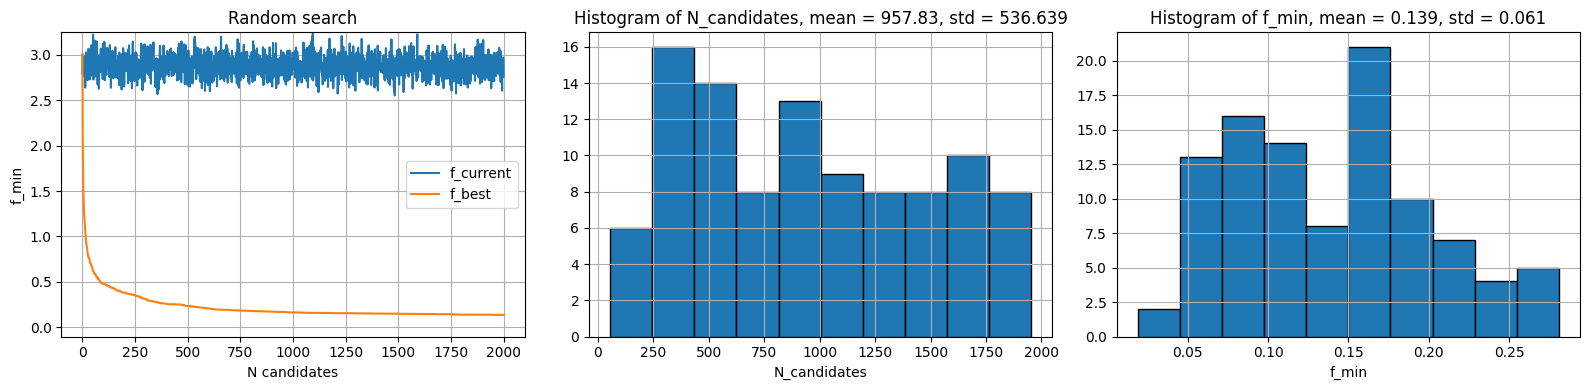

In [54]:
# Random search

f_visited_list = []; f_best_list = []
N_candidates = np.zeros((N,))
f_min_arr = np.zeros((N,))

for i in range(N):
    (x,f_min,x_visited,x_best) = random_search(x_init_arr[i],(x_min,x_max),max_iter*M)
    f_visited = [np.round(f_x(x), decimals=3) for x in x_visited]; f_visited_list.append(f_visited)
    f_best = [np.round(f_x(x), decimals=3) for x in x_best]; f_best_list.append(f_best)
    f_min = np.round(f_min, decimals=3)
    
    N_candidates[i] = np.where(f_visited == f_min)[0][0] + 1
    f_min_arr[i] = f_min

f_visited_avg = np.mean(np.array(f_visited_list),axis=0)
f_best_avg = np.mean(np.array(f_best_list),axis=0)

N_mean_arr[0] = np.round(np.mean(N_candidates),3)
N_std_arr[0] = np.round(np.std(N_candidates),3)
f_mean_arr[0] = np.round(np.mean(f_min_arr),3)
f_std_arr[0] = np.round(np.std(f_min_arr),3)

# display of results
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(f_visited_avg, label = "f_current")
plt.plot(f_best_avg, label = "f_best")
plt.xlabel('N candidates'); plt.ylabel('f_min')
plt.title('Random search')
plt.legend(); plt.ylim((-0.1,max(f_visited_avg))); plt.grid()
plt.subplot(1,3,2)
plt.hist(N_candidates, edgecolor='black', bins= int(np.sqrt(N))); plt.grid()
plt.xlabel('N_candidates'); plt.title('Histogram of N_candidates, mean = {}, std = {}'.format(N_mean_arr[0],N_std_arr[0]))
plt.subplot(1,3,3)
plt.hist(f_min_arr, edgecolor='black', bins= int(np.sqrt(N))); plt.grid()
plt.xlabel('f_min'); plt.title('Histogram of f_min, mean = {}, std = {}'.format(f_mean_arr[0], f_std_arr[0]))
plt.tight_layout()

<u>Tabelarni prikaz rezultata</u>

U sledećoj tabeli prikazani su:
- srednja vrednost i standardna devijacija potrebnog broja generisanih kandidata do nalaženja najboljeg rešenja (*N_mean* i *N_std*)    
- srednja vrednost i standardna devijacija procenjene minimalne vrednosti funkcije f(x) na posmatranom domenu (*f_mean* i *f_std*)  

Prikazani su rezultati za slučajnu pretragu i za simulirano kaljenje za 3 posmatrana profila temperature.

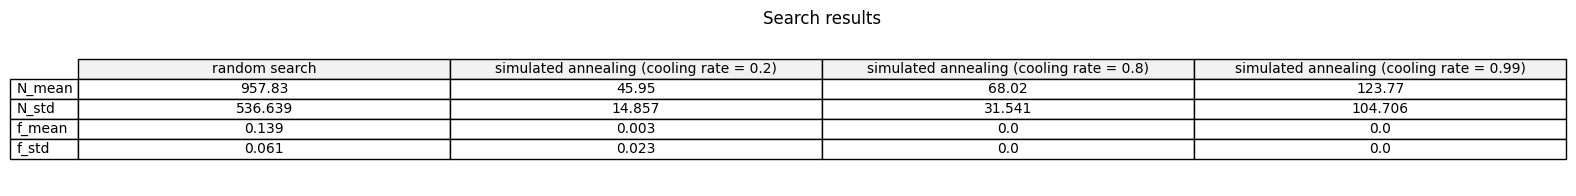

In [55]:
# Tabular representation of results

table_data = [N_mean_arr, N_std_arr, f_mean_arr, f_std_arr]
row_labels = ['N_mean','N_std','f_mean','f_std']
fig, ax = plt.subplots(figsize=(16,2))
table = ax.table(cellText=table_data, loc='center', colLabels=['random search', 'simulated annealing (cooling rate = 0.2)',\
            'simulated annealing (cooling rate = 0.8)','simulated annealing (cooling rate = 0.99)'],\
                rowLabels=row_labels, cellLoc='center', colColours=['#f2f2f2']*4)
ax.set_title('Search results'); ax.set_axis_off()
table.auto_set_font_size(False); table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.show()